In [1]:
import pyarrow.parquet as pq
import torch
import random
import time
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt



In [2]:
temp = pq.read_table('cleaned_taxi_data.parquet')
temp = temp.to_pandas()

trip_info = torch.tensor(temp.values, dtype = torch.float32)

In [10]:
# Base values
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [11]:
import torch
from torch.utils.data import random_split

# Normalize and Split Input Data (Train = 75%, Validation = 20%, Test = 5%)
torch.manual_seed(RANDOM_SEED)

# Define the sizes of the splits
train_size = int(0.75 * len(trip_info))
val_size = int(0.2 * len(trip_info))
test_size = len(trip_info) - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(trip_info, [train_size, val_size, test_size])


trip_inf_loc_train = list(range(0, 5)) + list(range(6, 172))
trip_inf_loc_val = list(range(0, 5)) + list(range(6, 172))
trip_inf_loc_test = list(range(0, 5)) + list(range(6, 172))

# Indices for targets
tip_inf_loc_train = [172, 173, 174, 175]
tip_inf_loc_val = [172, 173, 174, 175]
tip_inf_loc_test = [172, 173, 174, 175]

In [12]:
# Extract features and labels from train_dataset
x_train = []
y_train = []

for sample in train_dataset:
    features = sample[trip_inf_loc_train]  
    labels = sample[tip_inf_loc_train]    
    x_train.append(features)
    y_train.append(labels)

# Convert lists to tensors
x_train = torch.stack(x_train)
y_train = torch.stack(y_train)
print("X Train size:", x_train.size())
print("y Train size:", y_train.size())


X Train size: torch.Size([1707345, 171])
y Train size: torch.Size([1707345, 4])


In [13]:
x_val = []
y_val = []

for sample in val_dataset:
    features = sample[trip_inf_loc_val]
    labels = sample[tip_inf_loc_val]
    x_val.append(features)
    y_val.append(labels)

# Convert lists to tensors
x_val = torch.stack(x_val)
y_val = torch.stack(y_val)
print("X Val size:", x_val.size())
print("y Val size:", y_val.size())


X Val size: torch.Size([455292, 171])
y Val size: torch.Size([455292, 4])


In [14]:
x_test = []
y_test = []

for sample in test_dataset:
    features = sample[trip_inf_loc_test]  
    labels = sample[tip_inf_loc_test]    
    x_test.append(features)
    y_test.append(labels)

# Convert lists to tensors
x_test = torch.stack(x_test)
y_test = torch.stack(y_test)
print("X Test size:", x_test.size())
print("y Test size:", y_test.size())

X Test size: torch.Size([113824, 171])
y Test size: torch.Size([113824, 4])


In [15]:
# Assuming x_train, y_train, x_val, y_val, x_test, and y_test are already defined

# Create TensorDataset objects for train, validation, and test datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Define batch sizes
batch_size = 64

# Create DataLoader objects for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,drop_last=True)

# Example usage of train_loader (iterate over batches)
# for batch_idx, (features, targets) in enumerate(train_loader):
#     # Do something with each batch of features and targets
#     pass


In [21]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes

    ### 1st hidden layer this hidden layer is the main different between softmax regression
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

    ### Output layer
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()

         
    def forward(self, x):
        out = self.linear_1(x)
        out = torch.sigmoid(out)
        logits = self.linear_out(out)
        #probas = torch.softmax(logits, dim=1) softmax does this automatically
        return logits#, #probas


#################################
### Model Initialization
#################################

#random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=171,
            num_hidden_1=100,
            num_classes=4)



model = model.to(DEVICE)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.view(-1, 171).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            loss = F.cross_entropy(logits, targets)
            # or better (more numerically stable):
            # loss = F.cross_entropy(logits, targets)
            # see 
            # ../../other/pytorch-lossfunc-cheatsheet.md
            curr_loss += loss
        return float(curr_loss)/cnt



start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 171).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits = model(features)
        
        #y_onehot = to_onehot(targets, model.num_classes).to(DEVICE)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
        
    cost = compute_loss(model, train_loader)
    epoch_cost.append(cost)
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))


Epoch: 001/010 | Batch 000/26677 | Cost: 1.3075
Epoch: 001/010 | Batch 050/26677 | Cost: 0.7574
Epoch: 001/010 | Batch 100/26677 | Cost: 0.8917
Epoch: 001/010 | Batch 150/26677 | Cost: 0.9434
Epoch: 001/010 | Batch 200/26677 | Cost: 0.8750
Epoch: 001/010 | Batch 250/26677 | Cost: 0.7110
Epoch: 001/010 | Batch 300/26677 | Cost: 0.6974
Epoch: 001/010 | Batch 350/26677 | Cost: 0.6769
Epoch: 001/010 | Batch 400/26677 | Cost: 0.5936
Epoch: 001/010 | Batch 450/26677 | Cost: 0.5331
Epoch: 001/010 | Batch 500/26677 | Cost: 0.6766
Epoch: 001/010 | Batch 550/26677 | Cost: 0.4994
Epoch: 001/010 | Batch 600/26677 | Cost: 0.4095
Epoch: 001/010 | Batch 650/26677 | Cost: 0.3313
Epoch: 001/010 | Batch 700/26677 | Cost: 0.4035
Epoch: 001/010 | Batch 750/26677 | Cost: 0.4292
Epoch: 001/010 | Batch 800/26677 | Cost: 0.4378
Epoch: 001/010 | Batch 850/26677 | Cost: 0.3728
Epoch: 001/010 | Batch 900/26677 | Cost: 0.4461
Epoch: 001/010 | Batch 950/26677 | Cost: 0.4097
Epoch: 001/010 | Batch 1000/26677 | Cost

In [22]:
# start_time = time.time()
# minibatch_cost = []
# epoch_cost = []
# for epoch in range(NUM_EPOCHS):
#     model.train()
#     for batch_idx, (features, targets) in enumerate(train_loader):
#         # Training steps
#         features = features.view(-1, 171).to(DEVICE)
#         targets = targets.to(DEVICE)
            
#         ### FORWARD AND BACK PROP
#         logits = model(features)
#         cost = F.cross_entropy(logits, targets)
#         optimizer.zero_grad()
#         cost.backward()
#         minibatch_cost.append(cost)
#         ### UPDATE MODEL PARAMETERS
#         optimizer.step()
        
#         ### LOGGING
#         if not batch_idx % 50:
#             print('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
#                   % (epoch+1, NUM_EPOCHS, batch_idx, len(train_loader), cost))



#     # Validation loop
#     model.eval()  # Switch to evaluation mode
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for features, targets in val_loader:
#             features, targets = features.to(DEVICE), targets.to(DEVICE)
#             logits = model(features)
#             val_loss += F.cross_entropy(logits, targets, reduction='sum').item()
#             _, predicted = torch.max(logits, 1)
#             total += targets.size(0)
#             correct += (predicted == targets).sum().item()
    
#     # Calculate validation loss and accuracy
#     val_loss /= len(val_loader.dataset)
#     val_accuracy = correct / total
    
#     # Print validation metrics
#     print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')
        
#     ### LOGGING
#     cost = compute_loss(model, train_loader)
#     epoch_cost.append(cost)
#     print(f'Epoch: {epoch+1}/{NUM_EPOCHS}, Train Cost: {cost:.4f}')
#     print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

# print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')


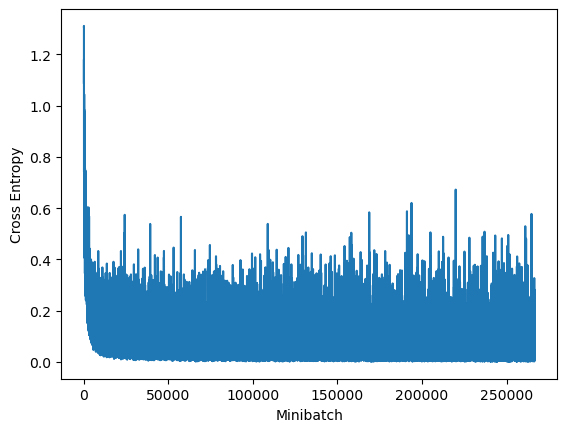

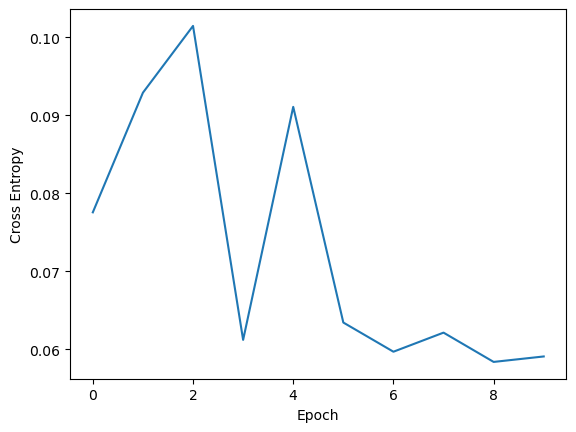

In [23]:

# Convert the lists to PyTorch tensors
minibatch_cost_tensor = torch.tensor(minibatch_cost)
epoch_cost_tensor = torch.tensor(epoch_cost)

# Convert the tensors to NumPy arrays
minibatch_cost_np = minibatch_cost_tensor.detach().numpy()
epoch_cost_np = epoch_cost_tensor.numpy()

# Plot minibatch cost
plt.plot(range(len(minibatch_cost_np)), minibatch_cost_np)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

# Plot epoch cost
plt.plot(range(len(epoch_cost_np)), epoch_cost_np)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()


In [24]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 171).to(DEVICE)
            targets = targets.to(DEVICE)
            targets = torch.argmax(targets,-1)
            logits = net(features)
            predicted_labels = torch.argmax(logits, -1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().item() 
    return correct_pred / num_examples * 100

print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))


Training Accuracy: 96.75
Test Accuracy: 96.67
